# VAR

In [1]:
from constants import YEARS, SEMESTERS
import numpy as np
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

### Load All data into panda frames

In [3]:
from dataLoading import getStudents, getGraduates, getSallaries
students = getStudents()
graduates = getGraduates()
sallaries = getSallaries()

### Prepare Data

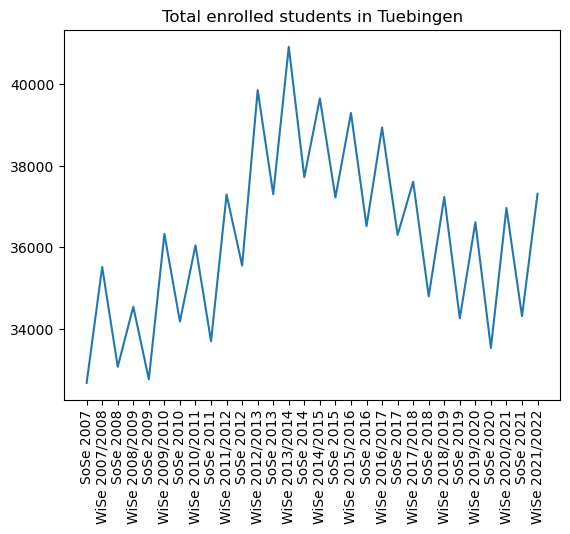

In [4]:
courses = students.index.levels[0].to_list()

interestingYears = YEARS[3:-4]

studentsInCourseHF = np.empty((len(courses), 0))

for year in interestingYears:
    data_for_year = students.loc[(courses, 'HF'), (year, SEMESTERS)].to_numpy(dtype=int).sum(axis=1)
    data_for_year = data_for_year.reshape((len(courses), 1))
    studentsInCourseHF = np.hstack((studentsInCourseHF, data_for_year))

studentsInCourseNF = np.empty((len(courses), 0))

for year in interestingYears:
    data_for_year = students.loc[(courses, 'NF'), (year, SEMESTERS)].to_numpy(dtype=int).sum(axis=1)
    data_for_year = data_for_year.reshape((len(courses), 1))
    studentsInCourseNF = np.hstack((studentsInCourseNF, data_for_year))

totalStudents = studentsInCourseHF.sum(axis=0) + studentsInCourseNF.sum(axis=0)
plt.plot(interestingYears, totalStudents)
plt.xticks(rotation='vertical')
plt.title('Total enrolled students in Tuebingen')
plt.show()

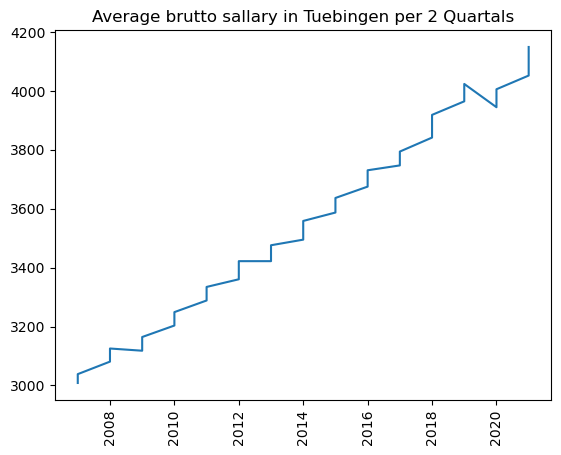

In [5]:
QUARTALS = ['1. Quartal', '2. Quartal', '3. Quartal', '4. Quartal']
SALLARY_YEARS = sallaries.index.levels[2]

bruttoSallary = sallaries.loc[('WZ08-B-08', 'Produzierendes Gewerbe und Dienstleistungsbereich', SALLARY_YEARS, QUARTALS), ('Insgesamt', 'Insgesamt', 'Durchschnittliche Bruttomonatsverdienste', 'EUR')].to_numpy(dtype=int)
bruttoSallary = bruttoSallary.reshape(-1, 2)
bruttoSallary = bruttoSallary.mean(axis=1)
plt.plot(SALLARY_YEARS.repeat(2), bruttoSallary)
plt.xticks(rotation='vertical')
plt.title('Average brutto sallary in Tuebingen per 2 Quartals')
plt.show()

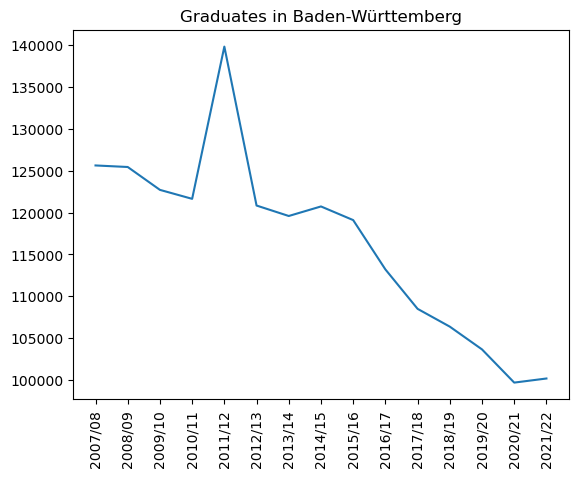

In [6]:
years = graduates.index.levels[1].to_list()
years = years[10:-1]
graduatesInBW = graduates.loc[('Insgesamt', years), ('Baden-Württemberg', 'Absolventen und Abgänger', 'Anzahl')].to_numpy()
graduatesInBW = np.where(graduatesInBW=='-', np.nan, graduatesInBW)
graduatesInBW = graduatesInBW.astype(float)
plt.plot(years, graduatesInBW)
plt.xticks(rotation='vertical')
plt.title('Graduates in Baden-Württemberg')
plt.show()

### Simple VAR-Modell for one subject, with data per semester

The data ranges from 2007 to (including) 2021.
Limited by the sallry data.

In [7]:
data = np.column_stack((totalStudents, bruttoSallary, graduatesInBW.repeat(2)))

model = VAR(data)

results = model.fit(maxlags=1)
# Forecasting
lagged_values = data[-1:]  # Use the last available values as lagged values
forecast = results.forecast(lagged_values, steps=2)
print(forecast)

[[37004.69315141  4192.95381184 98258.88762514]
 [36952.09201417  4238.99757013 96603.24269659]]


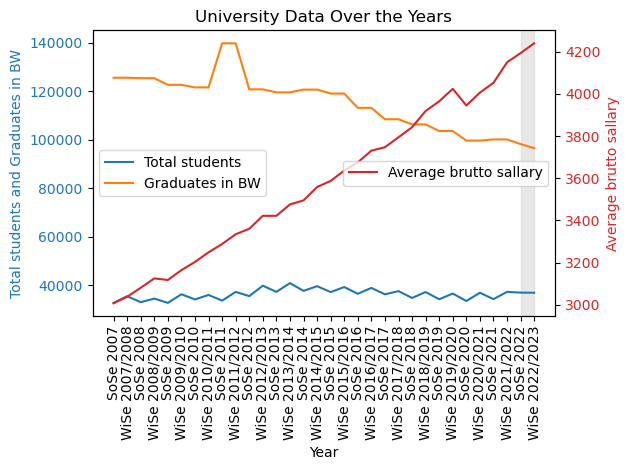

In [8]:
dataWithForecast = np.vstack((data, forecast))
yearsWithForecast = np.append(interestingYears, ['SoSe 2022', 'WiSe 2022/2023'])

fig, ax1 = plt.subplots()
plt.title('University Data Over the Years')
plt.xticks(rotation='vertical')
plt.axvspan(len(data), len(dataWithForecast) - 1, alpha=0.5, color='lightgrey')

ax1.set_xlabel('Year')
ax1.set_ylabel('Total students and Graduates in BW', color='tab:blue')
ax1.plot(yearsWithForecast, dataWithForecast[:, 0], color='tab:blue', label='Total students')
ax1.plot(yearsWithForecast, dataWithForecast[:, 2], color='tab:orange', label='Graduates in BW')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='center left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Average brutto sallary', color=color)  # we already handled the x-label with ax1
ax2.plot(yearsWithForecast, dataWithForecast[:, 1], color=color, label='Average brutto sallary')
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='center right')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()